In [67]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

**Functions**

In [76]:
# initialize parameters
ASSETS = ["BTC-USD", "ETH-USD"]
START = "2024-01-01"
END = "2025-10-27"
INTERVAL = "1d"  # daily prices
INITIAL_CAPITAL = 100000.0  # in USD per asset
POSITION_SIZE_USD = 10000.0  # allocate $10k per trade by default
ANNUALIZATION_DAYS = 365  # Crypto trades every day

In [69]:
# data collection from Yahoo finance
def fetch_data(ticker, start=START, end=END, interval=INTERVAL):
    # yfinance returns columns: Open, High, Low, Close, Volume
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if df.empty:
        raise ValueError(f"No data fetched for {ticker}. Check ticker or internet connection.")
    df = df.rename(columns={'Close':'close', 'Open':'open', 'High':'high', 'Low':'low', 'Volume':'volume'})
    df = df[['open', 'high', 'low', 'close', 'volume']]
    df.index.name = 'timestamp'
    return df

In [77]:
# performance metrics and plots
def annualized_return(ret_series, days_per_year=ANNUALIZATION_DAYS):
    total_ret = (1 + ret_series).prod()
    n_days = ret_series.shape[0]
    return total_ret ** (days_per_year / n_days) - 1

def annualized_vol(ret_series, days_per_year=ANNUALIZATION_DAYS):
    return ret_series.std() * np.sqrt(days_per_year)

def sharpe_ratio(ret_series, rf=0.0, days_per_year=ANNUALIZATION_DAYS):
    # rf is yearly
    excess = ret_series - rf / days_per_year
    ann_excess = excess.mean() * days_per_year
    ann_vol = excess.std() * np.sqrt(days_per_year)
    return ann_excess / (ann_vol + 1e-12)

def sortino_ratio(ret_series, rf=0.0, days_per_year=ANNUALIZATION_DAYS):
    # downside deviation: only negative returns considered
    downside = ret_series[ret_series < 0]
    if downside.empty:
        dd = 1e-12
    else:
        dd = downside.std() * np.sqrt(days_per_year)
    ann_excess = (ret_series.mean() - rf / days_per_year) * days_per_year
    return ann_excess / (dd + 1e-12)

def compute_drawdown(equity_series):
    peak = equity_series.cummax()
    dd = (equity_series - peak) / peak
    return dd

def max_drawdown(equity_series):
    dd = compute_drawdown(equity_series)
    return dd.min()

def summary_stats(trade_log_df, daily_ret_series, equity_series):
    stats = {} # dict
    stats['trades'] = len(trade_log_df) * 2
    wins = trade_log_df[trade_log_df['pnl'] > 0]
    losses = trade_log_df[trade_log_df['pnl'] <= 0]
    stats['win_rate'] = len(wins) / max(1, len(trade_log_df))
    stats['avg_win_pnl'] = wins['pnl'].mean() if not wins.empty else 0.0
    stats['avg_loss_pnl'] = losses['pnl'].mean() if not losses.empty else 0.0
    stats['total_pnl'] = trade_log_df['pnl'].sum()
    stats['annual_return'] = annualized_return(daily_ret_series)
    stats['annual_vol'] = annualized_vol(daily_ret_series)
    stats['sharpe'] = sharpe_ratio(daily_ret_series)
    stats['sortino'] = sortino_ratio(daily_ret_series)
    stats['max_drawdown'] = max_drawdown(equity_series)
    return stats

def plot_price_with_trades(asset, price_df, trades_df):
    fig, ax = plt.subplots(figsize=(13, 6))
    ax.plot(price_df.index, price_df['close'], label='Close price', color='gray')

    buy_trades = trades_df[trades_df['side'] == 'BUY']
    sell_trades = trades_df[trades_df['side'] == 'SELL']

    ax.scatter(buy_trades['entry_time'], buy_trades['entry_price'],
               marker='^', s=80, color='green', label='Buy', zorder=5)
    ax.scatter(sell_trades['exit_time'], sell_trades['exit_price'],
               marker='v', s=80, color='red', label='Sell', zorder=5)

    ax.set_title(f'Price with Trades: {asset}')
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_equity_and_drawdown(strategy_equity):
    fig, axs = plt.subplots(2, 1, figsize=(13, 10), sharex=True)

    # Equity plot
    axs[0].plot(strategy_equity.index, strategy_equity.values, label='Strategy Equity')
    axs[0].set_title('Strategy Equity (USD)')
    axs[0].legend()

    # Drawdown plot
    cum = strategy_equity / strategy_equity.iloc[0]
    dd = compute_drawdown(cum)
    axs[1].plot(dd.index, dd.values, label='Drawdown')
    axs[1].axhline(0, color='black', linewidth=0.5)
    axs[1].set_title('Drawdown')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [71]:
# strategy: momentum with correlation filter
def add_signals(price_data, window_mom=14, window_corr=20, corr_threshold=0.85):
    """
    Signals for trading BTC and ETH

    Parameters
    ----------
    price_data : dict of DataFrames with price data
        Each DataFrame must have 'close' column and share the same datetime index.
        {'BTC-USD': df_btc, 'ETH-USD': df_eth}
    window_mom : int
        Number of days for momentum computation (default 14 days)
    window_corr : int
        Number of days used for correlation computation (default 20)
    corr_threshold : float
        Threshold above which correlation adjustment is applied

    Returns
    -------
    updated_data : dict of DataFrames like price_data but with new signal columns
    """

    # Step 1: Combine for correlation calculation
    combined = pd.DataFrame({
    'BTC': price_data['BTC-USD']['close'].squeeze(),
    'ETH': price_data['ETH-USD']['close'].squeeze()
    })

    # Compute returns
    returns = combined.pct_change()

    # Step 2: Compute momentum (simple rolling mean of returns)
    momentum = returns.rolling(window_mom).mean()

    # Step 3: Rolling correlation
    rolling_corr = returns['BTC'].rolling(window_corr).corr(returns['ETH'])

    # Step 4: Initialize signal DataFrames
    signals = {}
    for asset in ['BTC-USD', 'ETH-USD']:
        signals[asset] = pd.Series(0, index=combined.index)

    # Step 5: Momentum-based signals
    signals['BTC-USD'][momentum['BTC'] > 0] = 1
    signals['ETH-USD'][momentum['ETH'] > 0] = 1

    # Step 6: Correlation adjustment
    for t in combined.index:
        if rolling_corr.loc[t] > corr_threshold:
            # If both long, pick stronger momentum
            if (signals['BTC-USD'].loc[t] == 1) and (signals['ETH-USD'].loc[t] == 1):
                if momentum.loc[t, 'BTC'] > momentum.loc[t, 'ETH']:
                    signals['ETH-USD'].loc[t] = 0
                else:
                    signals['BTC-USD'].loc[t] = 0

    # Step 7: Write signals back to each DataFrame
    updated_data = {}
    for asset, df in price_data.items():
        df = df.copy()
        df['signal'] = signals[asset].fillna(0)
        df['signal_shift'] = df['signal'].shift(1).fillna(0)
        df['trigger'] = df['signal'] - df['signal_shift']
        updated_data[asset] = df

    return updated_data


In [72]:
# execution and trade logging
def execution_trade_log(updated_data, initial_capital=INITIAL_CAPITAL, position_size_usd=POSITION_SIZE_USD):
  # updated_data : dict of two dataframes (btc and eth) from add_signals
  # initial_capital is the initial amount of money available per asset

  # initialize
  all_trade_logs = [] # list
  all_trade_log_buy_sell_separate = []
  all_equities = {}
  all_returns = {}

  for asset, df in updated_data.items():
    # df is the dataframe with price data, signals, signal_shift and triggers per asset (btc or eth)

    cash = initial_capital
    position = 0.0
    entry_price = None
    entry_time = None
    trade_log = [] # list with trades
    trade_log_buy_sell_separate = [] # list with separate entries for buy and sell orders
    daily_equity = [] # list

    for idx, row in df.iterrows():
      # assume for simplicity that we trade at close price
      price = row['close'].iloc[0]

      # entry
      if int(row['trigger'].iloc[0]) == 1 and position == 0:

        size = position_size_usd / price
        position = size
        entry_price = price
        entry_time = idx
        cash -= size * price

        print(f"[ENTRY] {asset} | Time: {idx} | Side: BUY | Price: {price:.2f} | Size: {size:.6f}")

        trade_log.append({
            'asset': asset,
            'entry_time': entry_time,
            'entry_price': entry_price,
            'exit_time': None,
            'exit_price': None,
            'size': size,
            'side': 'BUY',
            'pnl': None
        })

        trade_log_buy_sell_separate.append({
            'asset': asset,
            'entry_time': entry_time,
            'entry_price': entry_price,
            'size': size,
            'side': 'BUY'
        })

      # exit
      elif int(row['trigger'].iloc[0]) == -1 and position > 0: # no short sell
        exit_price = price
        exit_time = idx
        size = position
        pnl = (exit_price - entry_price) * size
        cash += size * exit_price
        position = 0.0

        print(f"[EXIT]  {asset} | Time: {idx} | Side: SELL | Price: {price:.2f} | Size: {size:.6f} | PnL: {pnl:.2f}")

        # update last trade entry
        trade_log[-1].update({
            'exit_time': exit_time,
            'exit_price': exit_price,
            'pnl': pnl
        })

        trade_log_buy_sell_separate.append({
            'asset': asset,
            'exit_time': exit_time,
            'exit_price': exit_price,
            'size': size,
            'side': 'SELL',
            'pnl': pnl
        })

      # record daily equity (cash value + portfolio value on that day)
      equity_per_day = cash + position * price
      daily_equity.append({'timestamp': idx, 'equity': equity_per_day})

    # Close position for this asset at the very end of sample at last price
    if position > 0:
      last_price = df["close"].squeeze().iloc[-1]
      exit_time = df.index[-1]
      size = position
      pnl = (last_price - entry_price) * position
      cash += position * last_price
      position = 0.0

      print(f"[CLOSE POSITION]  {asset} | Time: {idx} | Side: SELL | Price: {last_price:.2f} | Size: {size:.6f} | PnL: {pnl:.2f}")

      trade_log[-1].update({
          'exit_time': exit_time,
          'exit_price': last_price,
          'pnl': pnl
      })

      trade_log_buy_sell_separate.append({
            'asset': asset,
            'exit_time': exit_time,
            'exit_price': last_price,
            'size': size,
            'side': 'SELL',
            'pnl': pnl
        })

    # save results for this asset (btc or eth) as dataframes
    trade_buy_sell_separate_df = pd.DataFrame(trade_log_buy_sell_separate)
    trade_df = pd.DataFrame(trade_log)
    equity_df = pd.DataFrame(daily_equity).set_index('timestamp').sort_index()
    daily_returns = equity_df['equity'].pct_change().fillna(0)

    all_trade_log_buy_sell_separate.append(trade_buy_sell_separate_df)
    all_trade_logs.append(trade_df)
    all_equities[asset] = equity_df['equity']
    all_returns[asset] = daily_returns

  # Combine btc and eth
  combined_trades_separate = pd.concat(all_trade_log_buy_sell_separate, ignore_index=True) # dataframe
  combined_trades = pd.concat(all_trade_logs, ignore_index=True) # dataframe
  combined_equity = pd.DataFrame(all_equities).sum(axis=1).sort_index() # series
  combined_returns = combined_equity.pct_change().fillna(0) # series

  return combined_trades, combined_equity, combined_returns, combined_trades_separate


**Main: run trading applicaton**

In [73]:
# run trading application
price_data = {asset: fetch_data(asset) for asset in ASSETS}
updated_data = add_signals(price_data)
trades, equity, returns, trades_separate = execution_trade_log(updated_data)

# Print summary of performance stats
stats = summary_stats(trades, returns, equity)
print("\nPerformance Metrics Summary: ")
for perf_metric, value in stats.items():
    if isinstance(value, float):
        print(f"{perf_metric}: {value:.6g}")
    else:
        print(f"{perf_metric}: {value}")


/tmp/ipython-input-2151293910.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
/tmp/ipython-input-2151293910.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)


[ENTRY] BTC-USD | Time: 2024-01-17 00:00:00 | Side: BUY | Price: 42742.65 | Size: 0.233958
[EXIT]  BTC-USD | Time: 2024-01-18 00:00:00 | Side: SELL | Price: 41262.06 | Size: 0.233958 | PnL: -346.40
[ENTRY] BTC-USD | Time: 2024-01-28 00:00:00 | Side: BUY | Price: 42035.59 | Size: 0.237894
[EXIT]  BTC-USD | Time: 2024-01-30 00:00:00 | Side: SELL | Price: 42952.61 | Size: 0.237894 | PnL: 218.15
[ENTRY] BTC-USD | Time: 2024-02-01 00:00:00 | Side: BUY | Price: 43075.77 | Size: 0.232149
[EXIT]  BTC-USD | Time: 2024-03-18 00:00:00 | Side: SELL | Price: 67548.59 | Size: 0.232149 | PnL: 5681.34
[ENTRY] BTC-USD | Time: 2024-03-20 00:00:00 | Side: BUY | Price: 67913.67 | Size: 0.147246
[EXIT]  BTC-USD | Time: 2024-03-21 00:00:00 | Side: SELL | Price: 65491.39 | Size: 0.147246 | PnL: -356.67
[ENTRY] BTC-USD | Time: 2024-03-28 00:00:00 | Side: BUY | Price: 70744.95 | Size: 0.141353
[EXIT]  BTC-USD | Time: 2024-04-03 00:00:00 | Side: SELL | Price: 65980.81 | Size: 0.141353 | PnL: -673.42
[ENTRY] BTC

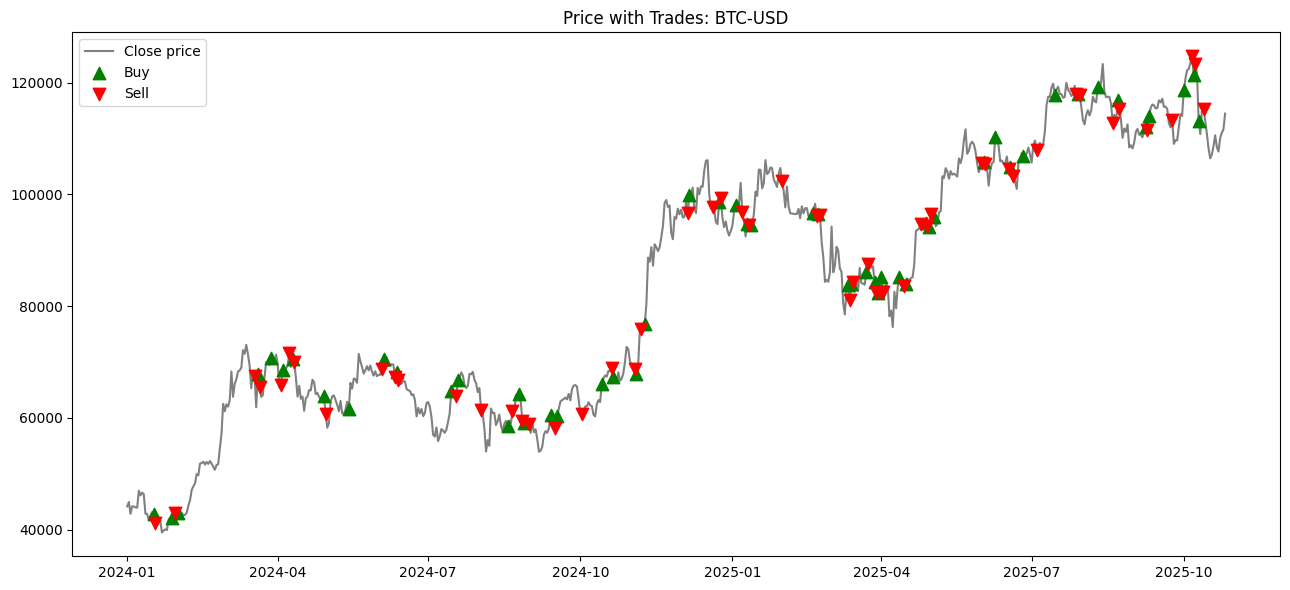

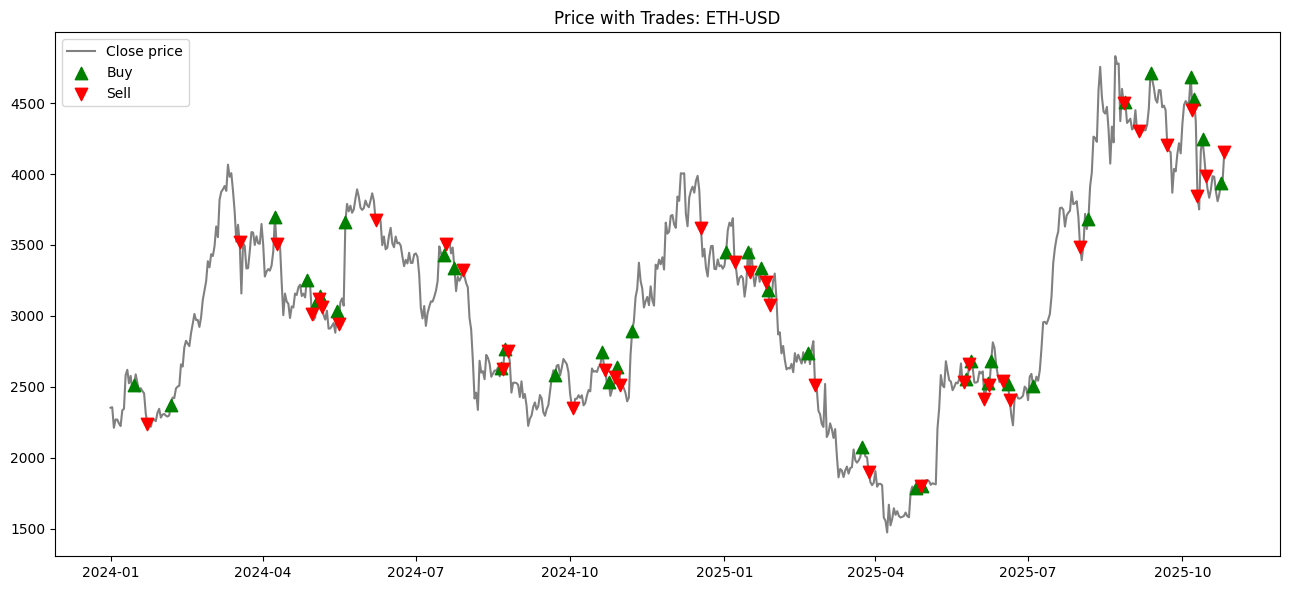

In [74]:
# Plot results for BTC
for asset in ASSETS:
  df = price_data[asset]
  plot_price_with_trades(asset, df, trades_separate[trades_separate['asset']==asset] if not trades_separate.empty else trades_separate)

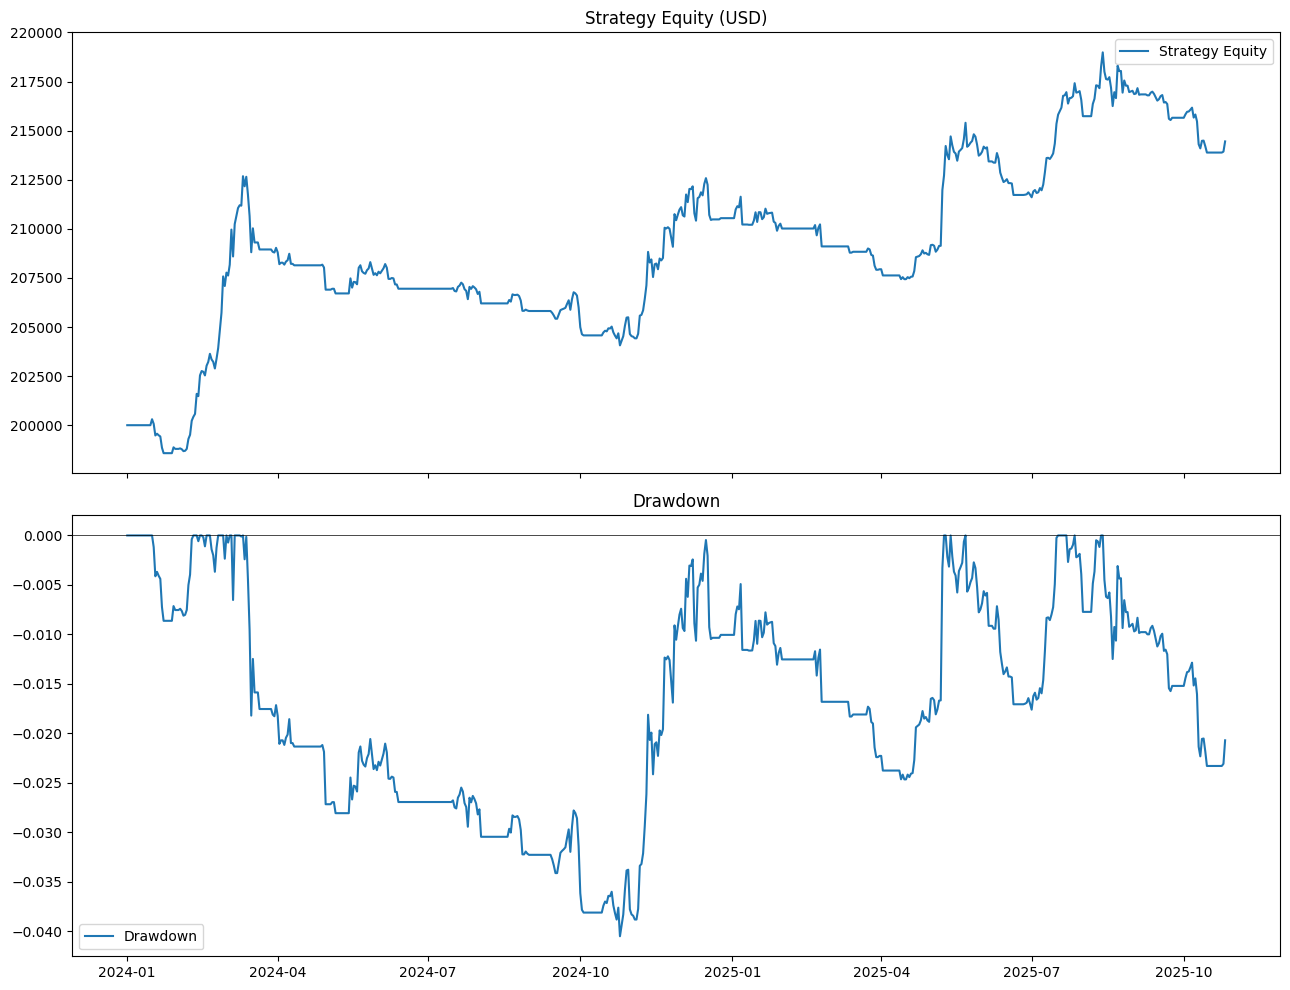

In [78]:
# Plot equity and drawdown
plot_equity_and_drawdown(equity)